<a href="https://colab.research.google.com/github/shirousaberx/skripsi/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-play-scraper
!pip install Sastrawi
!pip install indoNLP
!pip install tensorflow==2.15.0

from google_play_scraper import app
from google_play_scraper import Sort, reviews, reviews_all
import pandas as pd
import numpy as np

import json
import tensorflow as tf
import numpy as np
import urllib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization, Embedding
import keras
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import re
from indoNLP.preprocessing import remove_html, remove_url, replace_slang, replace_word_elongation, remove_stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

import json
import tensorflow as tf
import numpy as np
import urllib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization, Embedding

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Scrape data dan beri label

In [ ]:
REVIEW_COUNT = 200

result, continuation_token = reviews(
    'com.telkom.indihome.external',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    count=REVIEW_COUNT
)

# Convert json to table
df = pd.DataFrame(np.array(result), columns=['review'])
df = pd.DataFrame(df.pop('review').tolist())

df = df[['content', 'score', 'at']]
df['at'] = pd.to_datetime(df['at']).dt.date # Change datetime to date

## Beri label sementara
df['label'] = df.apply(lambda row: (1 if row['score'] > 3 else 0), axis=1) # Add label column based on the score

print('Total data = ', df.shape[0])

Filter dataframe sesuai tanggal (akan didapatkan sekitar 10 ribu ulasan)

In [ ]:
# Define the desired date range
start_date = '2024-02-23'
end_date = '2023-09-22'

# Filter the DataFrame for dates within the range (inclusive)
filtered_df = df[(df['at'] <= start_date) & (df['at'] >= end_date)]
df = filtered_df

Pada tahap ini, download dan labeli manual dataset. Setelah tahap ini, dataset sudah dianggap telah dilabeli manual

In [ ]:
df.to_csv('dataset.csv')

Load manually labeled dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/MyDrive/skripsi/dataset.csv')

Mounted at /content/gdrive


Preprocessing column 'content' pada dataframe

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Input: string
# output: preprocessed string
def preprocess_text(text):
  text = str(text)

  ## Hapus karakter non-ASCII
  text = re.sub(r'[^\x00-\x7F]+', '', text)

  ## Case folding (ubah ke huruf kecil)
  text = text.lower()

  ## Hapus tag html
  text = re.sub('<.*?>', '', text)

  ## Hapus URL
  text = re.sub(r'https?://\S+|www\.\S+', '', text)

  ## Hapus angka
  text = re.sub(r"\d+", "", text)

  ## Mengganti kata gaul menjadi kata formal
  text = replace_slang(text)

  ## Replace tanda baca dengan whitespace
  text = re.sub(r"[-,.;@#?!&$]+\ *", " ", text)

  ## Hapus whitespace berlebih di awal, antara kata, dan akhir
  text = re.sub(r'\s+', ' ', text)

  ## Menghandle word elongation
  text = replace_word_elongation(text)

  ## Stemming
  text = text.split(' ')
  exclude = ['lemot']
  stemmed_words = []
  for word in text:
    if word in exclude:
      stemmed_words.append(word)
    else:
      stemmed_words.append(stemmer.stem(word))
  text = ' '.join(stemmed_words)

  ## Remove stopwords
  # text = remove_stopwords(text)

  return text

In [ ]:
df['preprocessed_content'] = df['content'].map(preprocess_text)
df = df[df['preprocessed_content'] != '']  # Jika content kosong setelah preprocessing, buang row

Shuffle dataframe

In [ ]:
df = df.sample(frac=1) # shuffle dataframe
print('Jumlah data positif = ', df[df['label'] == 1].shape[0])
print('Jumlah data negatif = ', df[df['label'] == 0].shape[0])

Jumlah data positif =  5740
Jumlah data negatif =  4750


Latih model

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
DATA_COUNT = df.shape[0]

train_size = int(DATA_COUNT * 0.7)

Pisahkan data untuk train, dev, dan test set
train_df = df.iloc[:train_size]
dev_df = df.iloc[train_size:int(DATA_COUNT * 0.85)]
test_df = df.iloc[int(DATA_COUNT * 0.85):]

def train_BiGRU(learning_rate, batch_size):

  tf.keras.backend.clear_session()

  # Prepare vectorizer
  vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=max_length)

  vectorizer.adapt(train_df['preprocessed_content'])

  voc = vectorizer.get_vocabulary()
  word_index = dict(zip(voc, range(len(voc))))

  # Vectorize train, dev, and test data
  train_vectors = vectorizer(train_df['preprocessed_content'])
  dev_vectors = vectorizer(dev_df['preprocessed_content'])
  test_vectors = vectorizer(test_df['preprocessed_content'])

  # Convert the labels into numpy arrays
  train_labels = np.array(train_df['label'], dtype=np.float32)
  dev_labels = np.array(dev_df['label'], dtype=np.float32)
  test_labels = np.array(test_df['label'], dtype=np.float32)

  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(max_length,)),
      tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy', tf.keras.metrics.F1Score(average='micro', threshold=0.5)])

  history = model.fit(train_vectors, train_labels,
                      validation_data=(dev_vectors, dev_labels),
                      batch_size=batch_size,
                      epochs=10,
                      verbose=0)

  train_performance = model.evaluate(train_vectors, train_labels, verbose=0)
  dev_performance = model.evaluate(dev_vectors, dev_labels, verbose=0)
  test_performance = model.evaluate(test_vectors, test_labels, verbose=0)

  return (train_performance, dev_performance, test_performance)

Latih dengan berbagai learning rate dan batch size

In [ ]:
for batch_size in [256, 512, 1024]:
  for learning_rate in [0.01, 0.001, 0.0001]:
    print('learning rate = ', learning_rate, ' ========= batch size = ', batch_size)
    performance = train_BiGRU(learning_rate, batch_size)
    bigru_performances.append(performance)
    print(performance)

Plot Arsitektur Model

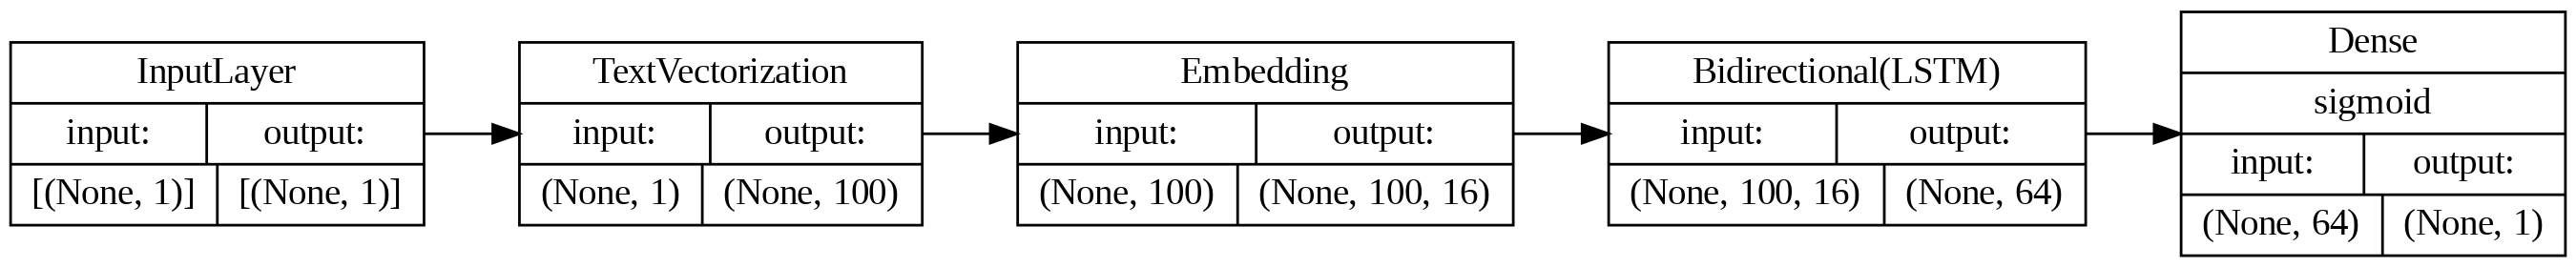

In [ ]:
tf.keras.backend.clear_session()

vocab_size = 10000
embedding_dim = 16
max_length = 100

vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=max_length)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    vectorizer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

tf.keras.utils.plot_model(model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=False,)

Coba prediksi sebuah kalimat

In [ ]:
x = 'saya sudah pesan beberapa hari yang lalu sampai sekarang enggak ada proses apa pun kata teknisi nya sampai pada jadwal yang di tentu tapi sampai sekarang enggak datang datang saya sudah hubung pisak indihome juga enggak ada tanggap'
x = preprocess_text(x)
x = vectorizer([x])

model.predict(x)

preprocessed text =  saya sudah pesan beberapa hari yang lalu sampai sekarang enggak ada proses apa pun kata teknisi nya sampai pada jadwal yang di tentu tapi sampai sekarang enggak datang datang saya sudah hubung pisak indihome juga enggak ada tanggap
1/1 [==============================] - 0s 30ms/step


array([[0.01377772]], dtype=float32)

Buat pipeline dari mulai dari vectorizer sampai model dan save ke google drive

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input([1], dtype=tf.string),
    vectorizer,
    model
])

model.save('/content/gdrive/MyDrive/skripsi/model')

Load end-to-end model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

model = tf.keras.models.load_model('/content/gdrive/MyDrive/skripsi/model')

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=tf.keras.losses.BinaryCrossentropy())

Mounted at /content/gdrive


Test end-to-end model

In [ ]:
# bisa langsung masukkin teks, sebelumnya harus lewat Text Vectorization dulu

model.predict(['saya sudah pesan beberapa hari yang lalu sampai sekarang enggak ada proses apa pun kata teknisi nya sampai pada jadwal yang di tentu tapi sampai sekarang enggak datang datang saya sudah hubung pisak indihome juga enggak ada tanggap'])

1/1 [==============================] - 0s 64ms/step


array([[0.8343423]], dtype=float32)

Cek prediksi yang salah pada train set

In [ ]:
train_df['prediction'] = model.predict(np.array(train_df['preprocessed_content']))
train_df['predicted_label'] = train_df.apply(lambda row: (1 if row['prediction'] >= 0.5 else 0), axis=1)
train_df[train_df['label'] != train_df['predicted_label']]

230/230 [==============================] - 4s 15ms/step


<ipython-input-18-06a48bb7a4eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['prediction'] = model.predict(np.array(train_df['preprocessed_content']))
<ipython-input-18-06a48bb7a4eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['predicted_label'] = train_df.apply(lambda row: (1 if row['prediction'] >= 0.5 else 0), axis=1)


,content,preprocessed_content,score,at,label,prediction,predicted_label
,,,,,,,
7189,hampir sebulan peningkatan layanan sangat tida...,hampir bulan tingkat layan sangat tidak puas,1,2023-11-06,0,0.659654,1
2584,Setiap ada keluhan tidak pernah di respon,tiap ada keluh tidak pernah di respon,1,2024-01-11,0,0.582374,1
2913,"Baru sekarang hilang sinyal, kirain harus ribe...",baru sekarang hilang sinyal ira harus ribet te...,5,2024-01-05,1,0.006503,0
9248,Gila,gila,1,2023-10-10,0,0.660029,1
750,Signal tidak bagus,signal tidak bagus,1,2024-02-13,0,0.830158,1
...,...,...,...,...,...,...,...
792,Laporan gangguan lewat aplikasi tidak sampai 2...,lapor ganggu lewat aplikasi tidak sampai jam s...,5,2024-02-12,1,0.092101,0
9379,gak sampe 1 jam laporan di tindak lanjuti mantap,enggak sampai jam lapor di tindak lanjut mantap,5,2023-10-09,1,0.455017,0
1799,tak bisa dipakai,tak bisa pakai,1,2024-01-22,0,0.575238,1


Cek prediksi yang salah pada dev set

In [ ]:
dev_df['prediction'] = model.predict(np.array(dev_df['preprocessed_content']))
dev_df['predicted_label'] = dev_df.apply(lambda row: (1 if row['prediction'] >= 0.5 else 0), axis=1)
dev_df[dev_df['label'] != dev_df['predicted_label']]

50/50 [==============================] - 1s 15ms/step


<ipython-input-19-a65611483821>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['prediction'] = model.predict(np.array(dev_df['preprocessed_content']))
<ipython-input-19-a65611483821>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['predicted_label'] = dev_df.apply(lambda row: (1 if row['prediction'] >= 0.5 else 0), axis=1)


,content,preprocessed_content,score,at,label,prediction,predicted_label
,,,,,,,
1838,Sinyal GK pernah putus,sinyal enggak pernah putus,5,2024-01-21,1,0.141842,0
6090,APK Telkomsel dan indihome tolollllll,apk telkomsel dan indihome tolol,1,2023-11-21,0,0.509149,1
2914,M no. Ikut. BBM..,sama no ikut bbm,5,2024-01-05,1,0.379804,0
9210,Hendaknya ada kemudahan untuk perpindahan pake...,hendak ada mudah untuk pindah paket bukan hany...,1,2023-10-11,0,0.890580,1
6949,Layak dapat Bintang 🌟,layak dapat bintang,5,2023-11-11,1,0.402830,0
...,...,...,...,...,...,...,...
7844,Tingkatkan experience customer,tingkat experience customer,4,2023-10-25,1,0.353347,0
5242,Selamat pagi mohon di bantu kecepatan wifi kam...,selamat pagi mohon di bantu cepat wifi kami ko...,5,2023-11-27,0,0.802827,1
7849,"Enak digunakan, tetapi sekarang agak lebih ser...",enak guna tetapi sekarang agak lebih sering ga...,4,2023-10-25,0,0.780545,1


Cek prediksi salah pada test set

In [ ]:
test_df['prediction'] = model.predict(np.array(test_df['preprocessed_content']))
test_df['predicted_label'] = test_df.apply(lambda row: (1 if row['prediction'] >= 0.5 else 0), axis=1)
test_df[test_df['label'] != test_df['predicted_label']]

50/50 [==============================] - 1s 15ms/step


<ipython-input-20-6060622a1295>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = model.predict(np.array(test_df['preprocessed_content']))
<ipython-input-20-6060622a1295>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = test_df.apply(lambda row: (1 if row['prediction'] >= 0.5 else 0), axis=1)


,content,preprocessed_content,score,at,label,prediction,predicted_label
,,,,,,,
2834,"Sudah beralih ke banyak provider. Mulai dari ""...",sudah alih ke banyak provider mulai dari media...,5,2024-01-06,1,0.426458,0
1581,Segini dulu karena baru pake ini aplikasi 👍,gin dulu karena baru pakai ini aplikasi,3,2024-01-26,0,0.954097,1
4812,"sekarang udah bisa ganti paket lewat aplikasi,...",sekarang sudah bisa ganti paket lewat aplikasi...,5,2023-12-04,1,0.147003,0
1052,"Layanan internet stabil,,, tidak terpengaruh c...",layan internet stabil tidak pengaruh cuaca cum...,4,2024-02-06,1,0.030431,0
6657,"fasilitas yg diberikan udh lumayan, namun blm ...",fasilitas yang beri sudah lumayan namun belum ...,3,2023-11-15,0,0.972715,1
9184,"Ditingkatkan terus informasi, promo & pelayana...",tingkat terus informasi promo layan,3,2023-10-11,0,0.981896,1
3066,Tidak lancar,tidak lancar,2,2024-01-03,0,0.872263,1
5953,Sudah dibuka.. Dan sangat lambat.. Semoga cepa...,sudah buka dan sangat lambat moga cepat baik,1,2023-11-22,0,0.964587,1
1112,Tq indiehome.,tq indiehome,5,2024-02-05,1,0.484280,0


Confusion matrix

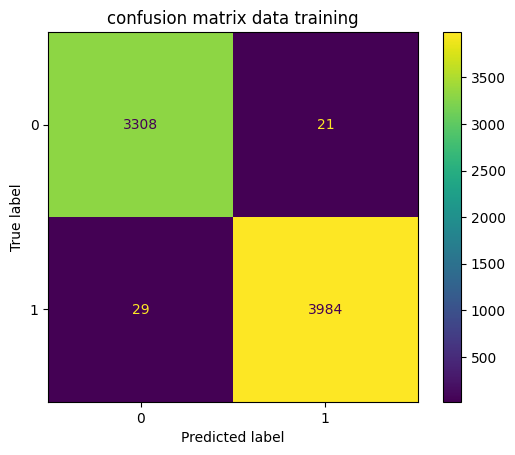

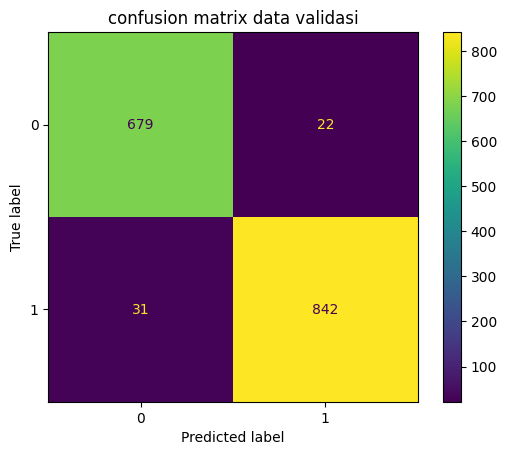

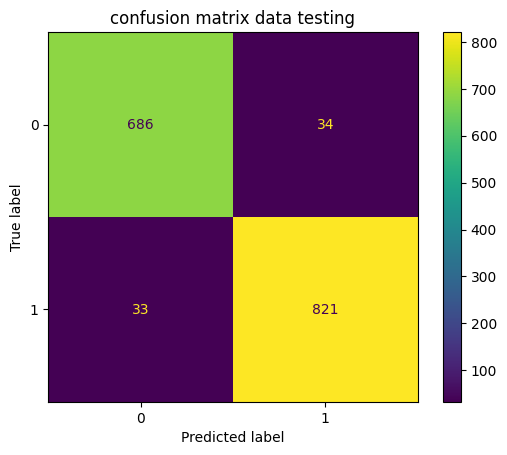

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# train confusion matrix
cm = confusion_matrix(train_df['label'], train_df['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('confusion matrix data training')
plt.show()

# dev confusion matrix
cm = confusion_matrix(dev_df['label'], dev_df['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('confusion matrix data validasi')
plt.show()

# test confusion matrix
cm = confusion_matrix(test_df['label'], test_df['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('confusion matrix data testing')
plt.show()

Kata terbanyak pada label positif dan negatif (stopwords dihilangkan)

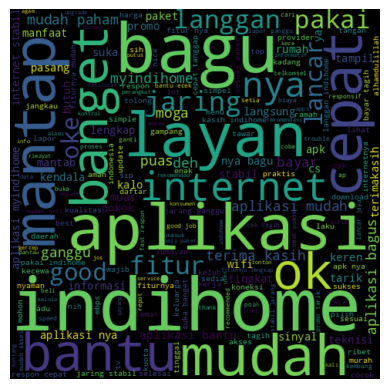

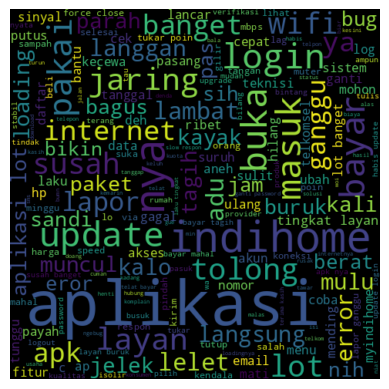

In [ ]:
# Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Word cloud positif
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(' '.join(remove_stopwords(text) for text in dev_df[dev_df['predicted_label'] == 1]['preprocessed_content']))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Word cloud negatif
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(' '.join(remove_stopwords(text) for text in dev_df[dev_df['predicted_label'] == 0]['preprocessed_content']))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

Plot 10 kata dengan frekuensi terbanyak pada kelas positif dan negatif

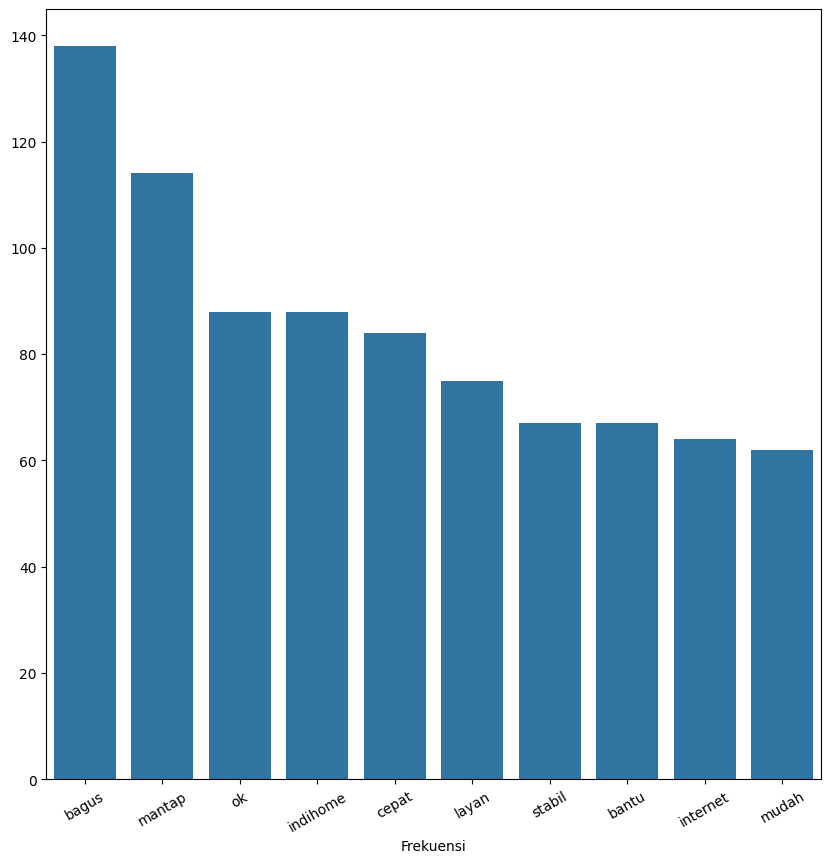

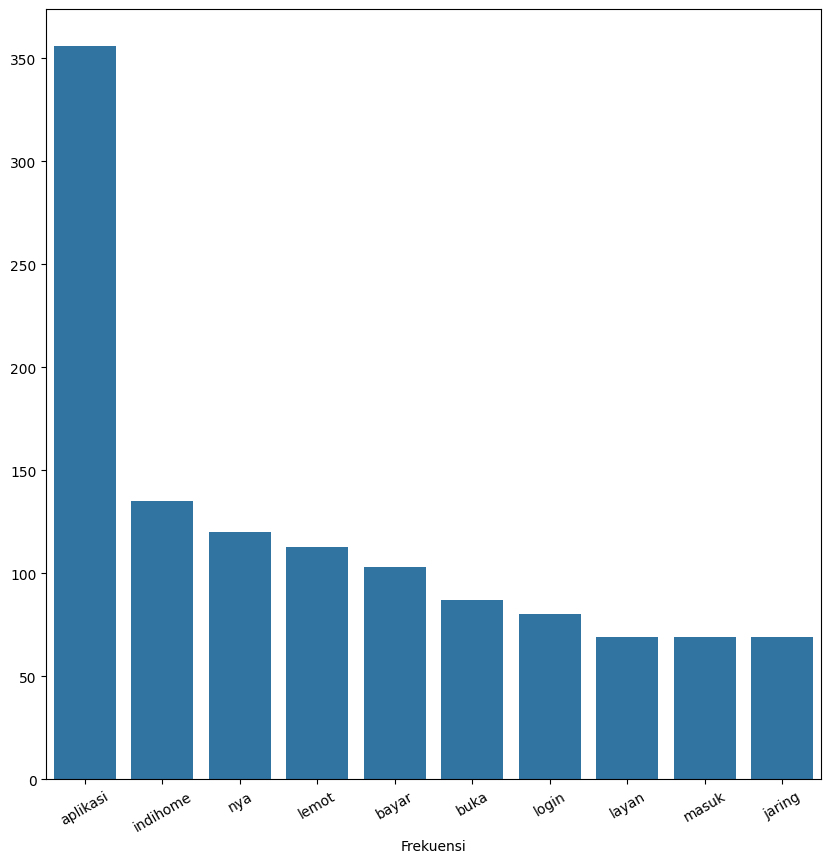

In [ ]:
import nltk
import seaborn as sns

## Text positif
# For every token that is in stopwords, remove it
text_positif = ' '.join(remove_stopwords(text) for text in test_df[test_df['predicted_label'] == 1]['preprocessed_content']).split()

# # Using nltk find all the frequencies
text_positif_freq = nltk.FreqDist(text_positif).most_common(10)

text_positif_freq = pd.Series(dict(text_positif_freq))

fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
posiif_plot = sns.barplot(x=text_positif_freq.index, y=text_positif_freq.values, ax=ax)
plt.xticks(rotation=30)
plt.xlabel('Kata')
plt.xlabel('Frekuensi')
plt.savefig('frekuensi_positif.png')

## text negatif
# For every token that is in stopwords, remove it
text_negatif = ' '.join(remove_stopwords(text) for text in test_df[test_df['predicted_label'] == 0]['preprocessed_content']).split()

# # Using nltk find all the frequencies
text_negatif_freq = nltk.FreqDist(text_negatif).most_common(10)

text_negatif_freq = pd.Series(dict(text_negatif_freq))

fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
posiif_plot = sns.barplot(x=text_negatif_freq.index, y=text_negatif_freq.values, ax=ax)
plt.xticks(rotation=30)
plt.xlabel('Kata')
plt.xlabel('Frekuensi')
plt.savefig('frekuensi_negatif.png')